In [6]:
import os
import warnings

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from scipy.stats import ks_2samp
import seaborn as sns
from synthesized.core import BasicSynthesizer
from synthesized.testing.synthetic_distributions import *
from synthesized.testing.synthetic_distributions import _plot_data

In [8]:
def log_values(synthesizer):
    print(' ', 'value types:')
    for value in synthesizer.values:
        print(' ', value.name, value)
    print()

def log_distance(df_original, df_synthesized):
    distances = list()
    for name in df_original:
        distance = ks_2samp(df_original[name], df_synthesized[name]).statistic
        suffix = ''
        if distance < 0.05:
            suffix += '*'
        if distance < 0.01:
            suffix += '*'
        distances.append('{:.3f}{}'.format(distance, suffix))
    print('/'.join(distances), end='  ')

In [9]:
size = 100000

def synthesize(df_original, num_iterations, num_logging, fn_logging=log_distance, **kwargs):
    start = time.time()
    with BasicSynthesizer(df_original, **kwargs) as synthesizer:
        log_values(synthesizer)
        value_types = {value.name: type(value) for value in synthesizer.values}
        df_synthesized = synthesizer.synthesize(n=len(df_original))
        fn_logging(df_original, df_synthesized)
        for _ in range(num_iterations // num_logging):
            synthesizer.learn(data=df_original, num_iterations=num_logging)
            df_synthesized = synthesizer.synthesize(n=len(df_original))
            assert len(df_synthesized) == len(df_original)
            fn_logging(df_original, df_synthesized)
        print()
        print(' ', 'took', time.time() - start, 's')
        return synthesizer.synthesize(n=len(df_original)), value_types

def plot(data, synthesized, value_types):
#     distances = [ks_2samp(data[col], synthesized[col])[0] for col in data.columns]
#     avg_distance = np.mean(distances)
#     evaluation[name + '_avg_distance'] = avg_distance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    ax1.set_title('original')
    ax2.set_title('synthesized')
    _plot_data(data, ax=ax1, value_types=value_types)
    _plot_data(synthesized, ax=ax2, value_types=value_types)

## 1. Single-column categorical

Interesting hyperparameters: entropy regularization, learning rate and decay, beta loss.

Only change between different categorical distributions: entropy regularization.

### (a) Bernoulli(0.3)

In [ ]:
df_original = create_bernoulli(probability=0.3, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=0.0,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5e-5),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.0
)

### (b) Bernoulli(0.1)

In [ ]:
df_original = create_bernoulli(probability=0.1, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=0.0,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5e-5),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.0
)

### (c) Categorical([0.5, 0.25, 0.125, ...])

In [ ]:
df_original = create_categorical(probabilities=[0.5, 0.25, 0.125, 0.0625, 0.0625], size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=0.0,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5e-5),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.0
)

## 2. Single-column continuous

Interesting hyperparameters: learning rate and decay, beta loss

### (a) Gaussian(0, 1)

In [ ]:
df_original = create_1d_gaussian(mean=0.0, std=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=0.0,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5e-5),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # losses
    categorical_weight=1.0, continuous_weight=0.1
)

### (b) Gaussian mixture N(0, 1) and N(3, 1)

Please note that fitting of distributions is not stable and for the same parameters of original distribution we can get a different fitted distribution. We actually should not fit any distribution in this case. Shouldn't we decrease threshold for distribution fitting?

In [ ]:
df_original = create_two_gaussian_mixtures(mean1=0.0, std1=1.0, mean2=3.0, std2=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=4000, num_logging=100,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=1e-5,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=0.0005),
    # optimizer
    optimizer='adam', learning_rate=3e-3, decay_steps=100, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128
)

#### (i) Production-like settings which sould produce reasonable result

In [ ]:
df_original = create_two_gaussian_mixtures(mean1=0.0, std1=1.0, mean2=3.0, std2=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=5000, num_logging=100,
    # encoder/decoder
    network_type='mlp', capacity=128, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=1e-5, # weight_decay=1e-5
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=0.001),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=1000, decay_rate=0.9,
    clip_gradients=1.0, batch_size=64
)

In [ ]:
df_original.hist(bins=100)
df_synthesized.hist(bins=100)

## 3. Two-column product distributions

### (a) Bernoulli(0.1) x Bernoulli(0.1)

Same hyperparameters as for single-column case, but slightly increased entropy regularization value.

In [ ]:
df_original = product(
    df1=create_bernoulli(probability=0.1, size=size),
    df2=create_bernoulli(probability=0.1, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=1e-3,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5.0),
    # optimizer
    optimizer='adam', learning_rate=1e-5, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.06
)

### (b) Gaussian(1, 1) x Gaussian(-1, 1)

In [ ]:
df_original = product(
    df1=create_1d_gaussian(mean=1.0, std=1.0, size=size),
    df2=create_1d_gaussian(mean=-1.0, std=1.0, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=1e-3,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=0.0004),
    # optimizer
    optimizer='adam', learning_rate=3e-3, decay_steps=50, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128
)

### (c) Bernoulli x Gaussian

#### (i) Uniform loss weights

In [ ]:
df_original = product(
    df1=create_bernoulli(probability=0.1, size=size),
    df2=create_1d_gaussian(mean=0.0, std=1.0, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=2, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=1e-3,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=5.0),
    # optimizer
    optimizer='adam', learning_rate=1e-5, decay_steps=200, decay_rate=0.5,
    clip_gradients=1.0, batch_size=128,
    # losses
    categorical_weight=1.0, continuous_weight=1.0,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.05
)

#### (ii) Biased loss weights

In [57]:
df_original = product(
    df1=create_bernoulli(probability=0.1, size=size),
    df2=create_1d_gaussian(mean=0.0, std=1.0, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # encoder/decoder
    network_type='mlp', capacity=512, depth=4, layer_type='dense',
    batchnorm=True, activation='relu', weight_decay=0.0,
    # encoding
    encoding_type='variational', encoding_size=512, encoding_kwargs=dict(beta=2e-5),
    # optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=300, decay_rate=0.5,
    clip_gradients=1.0, batch_size=512,
    # losses
    categorical_weight=1.0, continuous_weight=0.04,
    # categorical
    smoothing=0.0, moving_average=True, similarity_regularization=0.0,
    entropy_regularization=0.0
)

  value types:
  x1 categorical2-281
  x2 continuous-log_normal

0.083/0.247  0.033*/0.135  0.022*/0.100  0.023*/0.090  0.045*/0.083  0.033*/0.082  0.021*/0.083  0.037*/0.080  0.028*/0.086  0.046*/0.073  0.033*/0.071  0.042*/0.071  0.039*/0.072  0.032*/0.064  0.028*/0.071  0.045*/0.063  0.031*/0.073  0.035*/0.068  0.040*/0.066  0.031*/0.060  0.036*/0.072  0.034*/0.058  0.026*/0.065  0.021*/0.068  0.028*/0.064  0.034*/0.069  0.033*/0.067  0.031*/0.068  0.032*/0.063  0.018*/0.066  0.022*/0.065  0.030*/0.057  0.029*/0.062  0.030*/0.066  0.026*/0.059  0.027*/0.065  0.028*/0.058  0.029*/0.062  0.032*/0.055  0.030*/0.055  0.027*/0.060  0.028*/0.058  0.026*/0.059  0.024*/0.064  0.026*/0.059  0.029*/0.057  0.025*/0.058  0.029*/0.060  0.030*/0.059  0.029*/0.054  0.030*/0.055  
  took 224.0756800174713 s


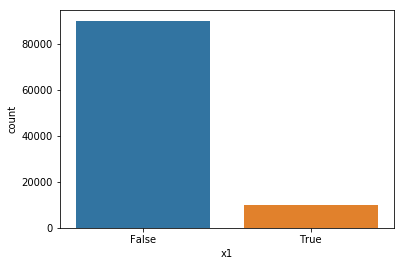

In [53]:
sns.countplot(df_original['x1'])

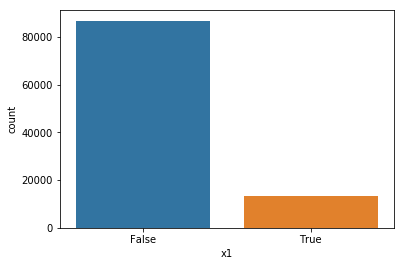

In [54]:
sns.countplot(df_synthesized['x1'])

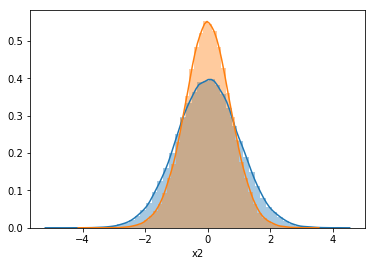

In [55]:
sns.distplot(df_original['x2'])
sns.distplot(df_synthesized['x2'])